In [98]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.misc as misc
import math
import imageio

import itertools

# Operator imports
import ndoperators as ops
import llops as yp

# Libwallerlab imports
import libwallerlab.utilities
from ndoperators.solvers import iterative, objectivefunctions
import libwallerlab.projects.motiondeblur as md
import libwallerlab.algorithms
import libwallerlab.utilities.simulation as sim
import libwallerlab.utilities.noise as noise

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
ops.setDefaultBackend('numpy') # arrayfire or numpy
ops.setDefaultDatatype('complex32')

global_dtype = yp.config.default_dtype
global_backend = yp.config.default_backend

In [100]:
def get_centered_horizontal_blur_kernel(illum_vec, normalization, object_size):
    illum_vec = normalization * illum_vec / sum(illum_vec)
    blur_kernel = yp.zeros(object_size)
    mid_y = int(np.round(object_size[0] / 2)); mid_x = (object_size[1] / 2)
    start_x = int(np.round(mid_x - len(illum_vec)/2)) 
    end_x = start_x + len(illum_vec)
    blur_kernel[mid_y, start_x:end_x] = illum_vec
    return blur_kernel, illum_vec 

# Simple Simulation



In [101]:
measurement_size = np.array((128,128))
image_size = measurement_size 

# Create test object
brain = sim.testObject('brain', image_size + np.array([2,2]), color_channel=2, dtype=yp.getNativeDatatype(global_dtype, 'numpy'))
object_true = yp.astype(yp.changeBackend(brain[1:-1,1:-1], global_backend), global_dtype)


blur_length = int(measurement_size[1]*0.2)
illum, _ = md.blurkernel.genRandInitialization(blur_length, 0.5)
# generate normalized blur kernel
blur_kernel, illum = get_centered_horizontal_blur_kernel(illum, 0.9, image_size)

C = ops.Convolution(blur_kernel, mode='circular')
y_true = C * object_true 
y = y_true + 0.001*noise.add(y_true, type='poisson')
y = yp.astype(y, global_dtype)



## Defining Denoisers Regularization Object

<IPython.core.display.Javascript object>


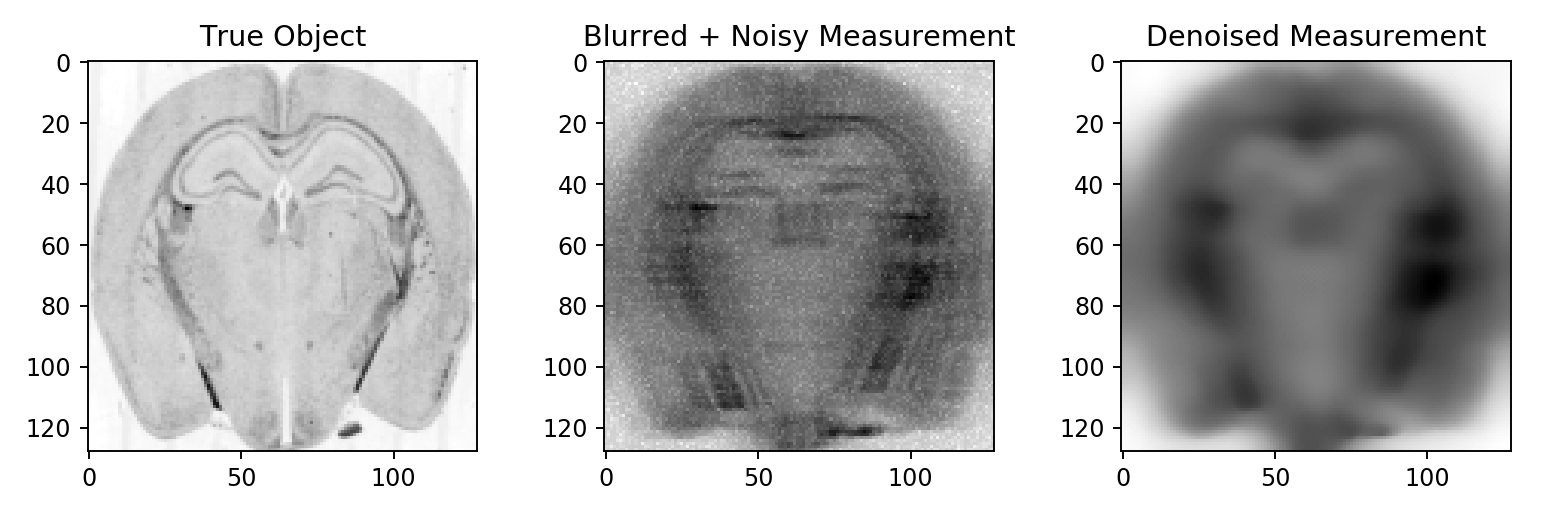

In [5]:
RED = ops.solvers.regularizers.RegDenoiser(image_size, denoise_type='tv', multichannel=False, weight=0.01)
RED.gradient_check(use_l2=False)

plt.figure(figsize=[9,3]); 
plt.subplot (1,3,1); plt.imshow(np.abs(object_true), cmap='gray'); plt.title('True Object')
plt.subplot (1,3,2); plt.imshow(np.abs(y), cmap='gray'); plt.title('Blurred + Noisy Measurement')
plt.subplot (1,3,3); plt.imshow(np.abs(RED.denoiser(y)), cmap='gray'); plt.title('Denoised Measurement')
plt.tight_layout()


## Reconstruction 

In [6]:
# Create data fidelity objective
data_fidelity_term = objectivefunctions.L2(C, y)

# Generate cost function (with regularization)
reg_weight = 4
cost_function = (data_fidelity_term) + 0.1 * (RED)

optimizer_reg = iterative.Fista(cost_function)
optimizer_unreg = iterative.Fista(data_fidelity_term)
initialization = yp.mean(y) * yp.ones(C.N) # zero initialization can be bad for denoiser
# initialization = yp.randn(C.N)



In [7]:
iteration_count = 100

In [8]:
object_recovered_reg = optimizer_reg.solve(initialization=initialization,
                                     step_size=0.1,
                                     nesterov_restart_enabled=True,
                                     use_nesterov_acceleration=True,
                                     let_diverge=True,
                                     iteration_count=iteration_count,
                                     display_type='text',
                                     display_iteration_delta=max((iteration_count // 10), 1))


Minimizing function:


<IPython.core.display.Latex object>

|  Iter  |      Cost      | Elapsed time (s) |  Norm of Step  | Memory Usage (CPU/GPU) |
+ ------ + -------------- + ---------------- + -------------- + ---------------------- +
|    0   |    6.06e+01    |       0.00       |    0.00e+00    |  175.0 MB /    0.0 MB  |
|   10   |    1.42e-01    |       1.93       |    9.37e-01    |  177.1 MB /    0.0 MB  |
|   20   |    1.21e-02    |       3.37       |    1.31e-03    |  177.1 MB /    0.0 MB  |
|   30   |    1.09e-02    |       4.74       |    6.48e-04    |  177.3 MB /    0.0 MB  |
|   40   |    1.04e-02    |       6.16       |    5.34e-04    |  177.3 MB /    0.0 MB  |
|   50   |    1.03e-02    |       7.51       |    1.98e-04    |  177.3 MB /    0.0 MB  |
|   60   |    1.03e-02    |       9.04       |    3.81e-05    |  177.3 MB /    0.0 MB  |
|   70   |    1.03e-02    |      10.67       |    7.63e-06    |  177.3 MB /    0.0 MB  |
|   80   |    1.03e-02    |      12.07       |    0.00e+00    |  177.3 MB /    0.0 MB  |
|   90   |    1.03e-0

In [9]:
object_recovered_unreg = optimizer_unreg.solve(initialization=initialization,
                                     step_size=0.1,
                                     nesterov_restart_enabled=True,
                                     use_nesterov_acceleration=True,
                                     let_diverge=True,
                                     iteration_count=iteration_count,
                                     display_type='text',
                                     display_iteration_delta=max((iteration_count // 10), 1))


Minimizing function:


<IPython.core.display.Latex object>

|  Iter  |      Cost      | Elapsed time (s) |  Norm of Step  | Memory Usage (CPU/GPU) |
+ ------ + -------------- + ---------------- + -------------- + ---------------------- +
|    0   |    6.06e+01    |       0.00       |    0.00e+00    |  177.3 MB /    0.0 MB  |
|   10   |    1.40e-01    |       0.09       |    9.37e-01    |  177.3 MB /    0.0 MB  |
|   20   |    8.69e-03    |       0.17       |    1.32e-03    |  177.3 MB /    0.0 MB  |
|   30   |    6.36e-03    |       0.24       |    6.71e-04    |  177.3 MB /    0.0 MB  |
|   40   |    4.01e-03    |       0.32       |    4.96e-04    |  177.3 MB /    0.0 MB  |
|   50   |    2.61e-03    |       0.40       |    4.96e-04    |  177.3 MB /    0.0 MB  |
|   60   |    1.88e-03    |       0.46       |    1.75e-04    |  177.3 MB /    0.0 MB  |
|   70   |    1.45e-03    |       0.53       |    2.14e-04    |  177.3 MB /    0.0 MB  |
|   80   |    1.06e-03    |       0.61       |    3.05e-05    |  177.3 MB /    0.0 MB  |
|   90   |    7.77e-0

<IPython.core.display.Javascript object>


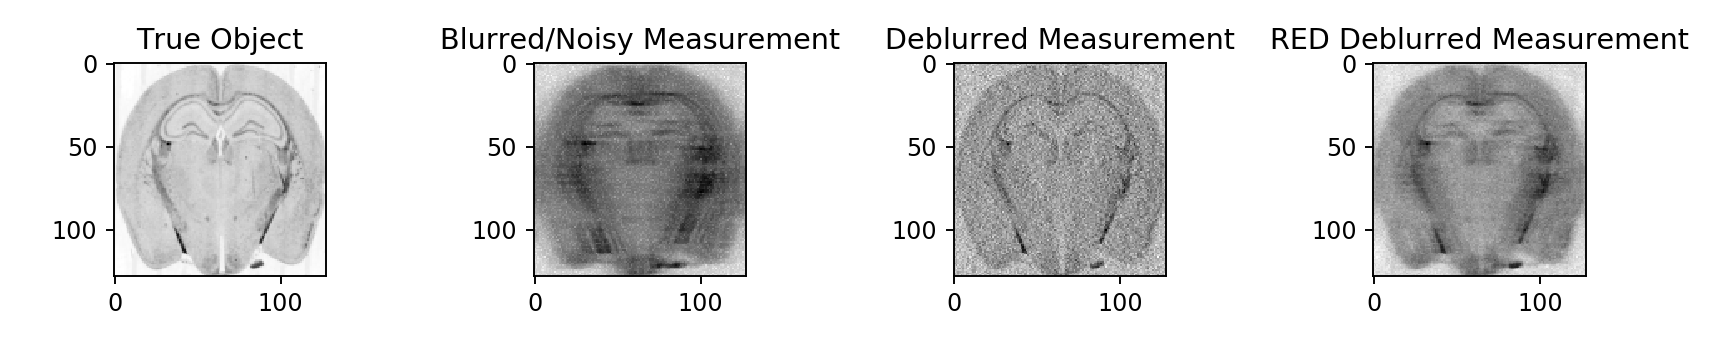

In [10]:
plt.figure(figsize=[10,2]); 
plt.subplot (1,4,1); plt.imshow(np.abs(object_true), cmap='gray'); plt.title('True Object')
plt.subplot (1,4,2); plt.imshow(np.abs(y), cmap='gray'); plt.title('Blurred/Noisy Measurement')
plt.subplot (1,4,3); plt.imshow(np.abs(object_recovered_unreg), cmap='gray'); plt.title('Deblurred Measurement')
plt.subplot (1,4,4); plt.imshow(np.abs(object_recovered_reg), cmap='gray'); plt.title('RED Deblurred Measurement')
plt.tight_layout()

# Test Bed

Testing different parameters, regularization weights, and denoisers.

In [104]:
def baseline_reconstruction(C,y,solve_display=None):
    object_recovered_unreg = solve(C,y,display=solve_display,reg=None)
    plt.figure(figsize=[8,2]); 
    plt.subplot (1,3,1); plt.imshow(np.abs(object_true), cmap='gray'); plt.title('True'); plt.axis('off')
    plt.subplot (1,3,2); plt.imshow(np.abs(y), cmap='gray'); plt.title('Measurement'); plt.axis('off')
    plt.subplot (1,3,3); plt.imshow(np.abs(object_recovered_unreg), cmap='gray'); plt.title('Deblurred'); plt.axis('off')
    plt.tight_layout()
    
def compare_reconstructions(C,y,reg_weight,solve_display=None,denoise_type='tv',**kwargs):
    RED = get_RED(denoise_type,**kwargs)
    object_recovered_reg = solve(C,y,display=solve_display,reg=(reg_weight * RED))
    plt.figure(figsize=[6,2]); 
    plt.subplot (1,2,1); plt.imshow(np.abs(RED.denoiser(y)), cmap='gray'); plt.title('Denoised\n'+denoise_type+': '+str(kwargs)); plt.axis('off')
    plt.subplot (1,2,2); plt.imshow(np.abs(object_recovered_reg), cmap='gray'); plt.title('RED Deblurred '+str(reg_weight)); plt.axis('off')
    plt.tight_layout()

def get_RED(denoise_type, **kwargs):
    RED = ops.solvers.regularizers.RegDenoiser(image_size, denoise_type=denoise_type, **kwargs)
    return RED

def solve(C,y,display=None,reg=None):
    # Create data fidelity objective
    data_fidelity_term = objectivefunctions.L2(C, y)

    # Generate cost function
    if reg is not None:
        cost_function = data_fidelity_term + reg
    else:
        cost_function = data_fidelity_term
    optimizer = iterative.Fista(cost_function)
    initialization = yp.mean(y) * yp.ones(C.N)
    
    # Solve
    iteration_count=100
    object_recovered = optimizer.solve(initialization=initialization,
                                     step_size=0.1,
                                     nesterov_restart_enabled=True,
                                     use_nesterov_acceleration=True,
                                     let_diverge=True,
                                     iteration_count=iteration_count,
                                     display_type=display,
                                     display_iteration_delta=max((iteration_count // 3), 1))
    return object_recovered

## Total Variation Parameter Search

<IPython.core.display.Javascript object>


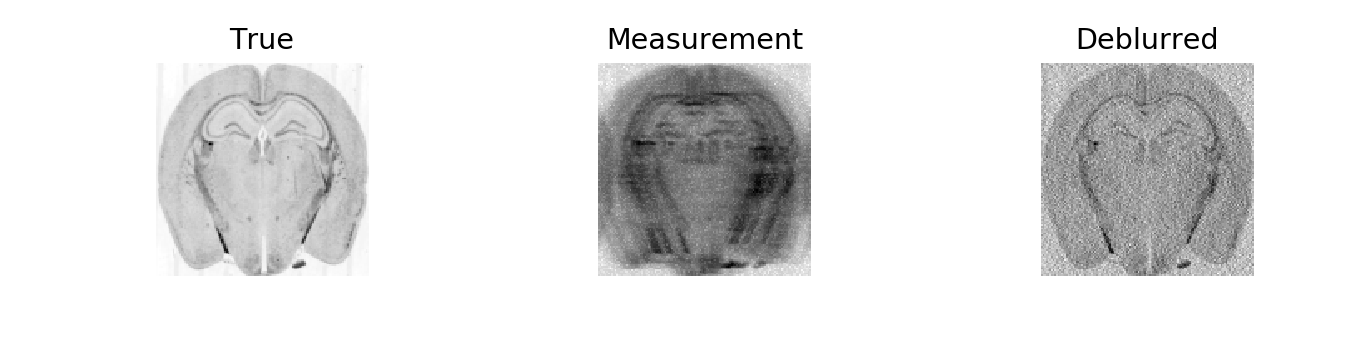

<IPython.core.display.Javascript object>


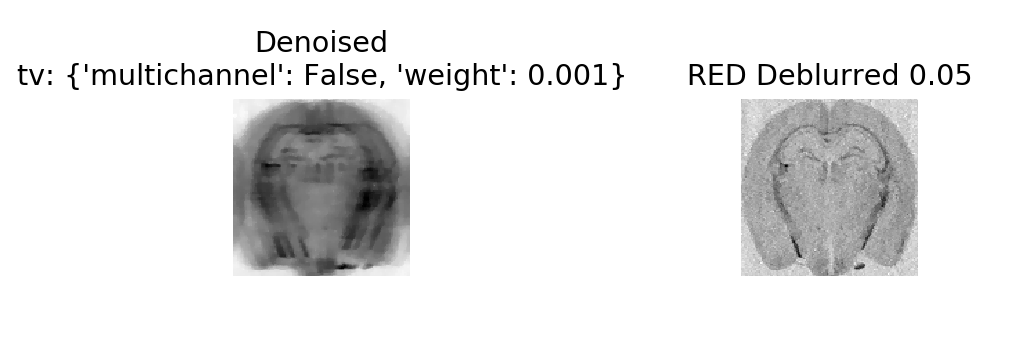

<IPython.core.display.Javascript object>


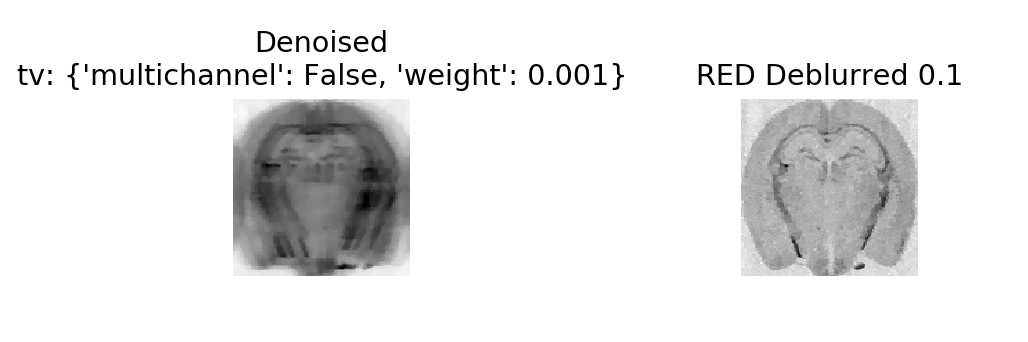

<IPython.core.display.Javascript object>


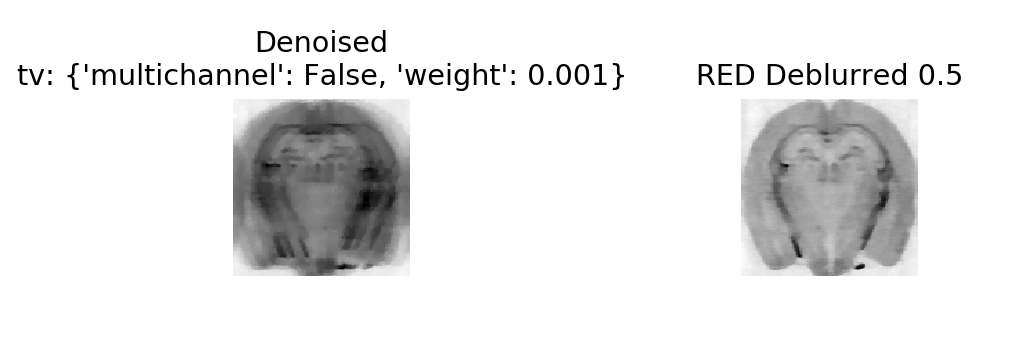

In [105]:
baseline_reconstruction(C,y)

for reg_weight in [0.05,0.1,0.5]:
    compare_reconstructions(C,y,reg_weight,denoise_type='tv',multichannel=False,weight=0.001)

## Bilateral Parameter Search

<IPython.core.display.Javascript object>


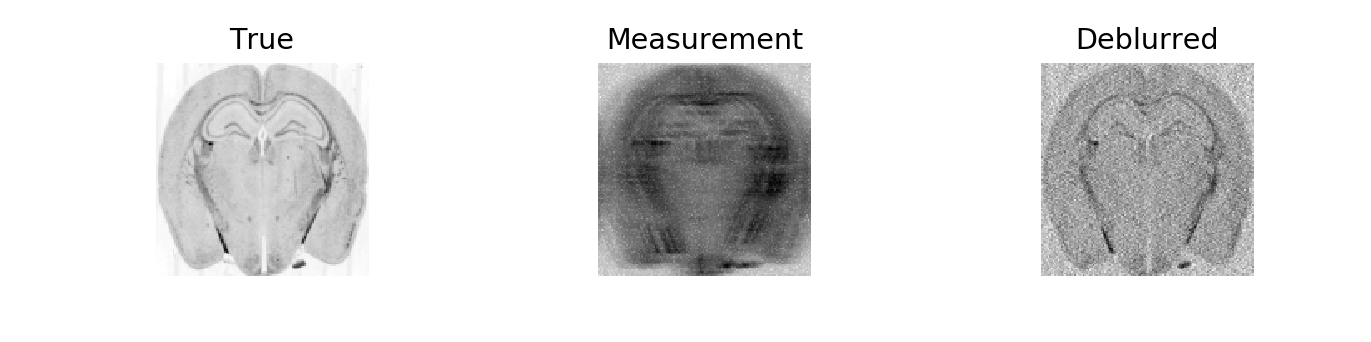

<IPython.core.display.Javascript object>


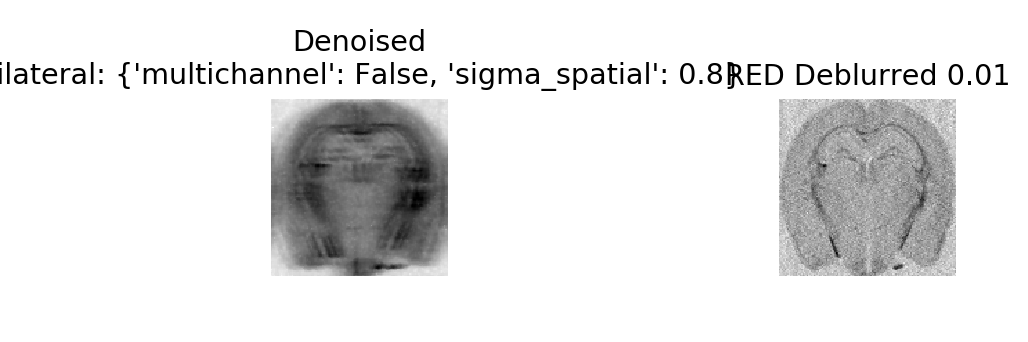

<IPython.core.display.Javascript object>


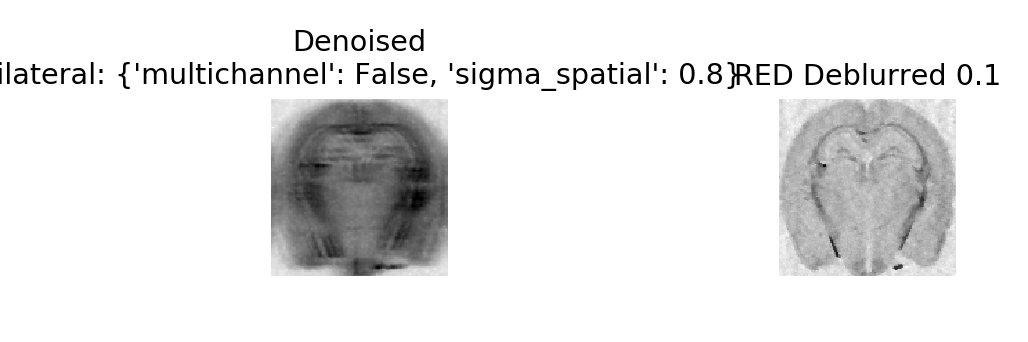

<IPython.core.display.Javascript object>


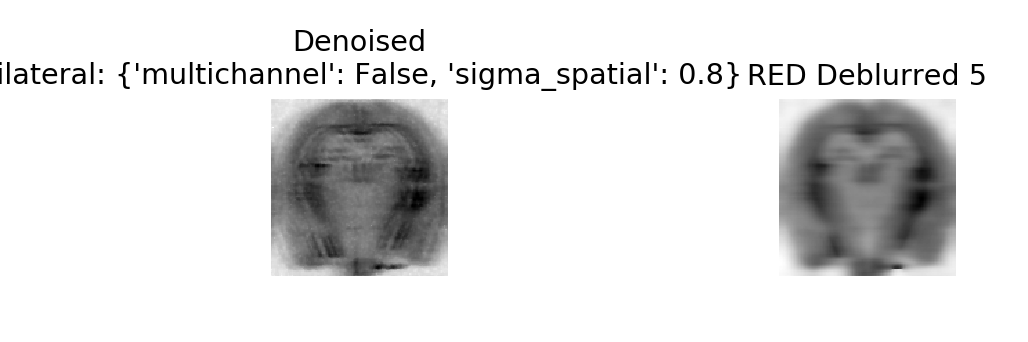

In [66]:
baseline_reconstruction(C,y)

for reg_weight in [0.01,0.1,0.5]:
    compare_reconstructions(C,y,reg_weight,denoise_type='bilateral',multichannel=False,sigma_spatial=0.8)

## Wavelet Parameter Search

<IPython.core.display.Javascript object>


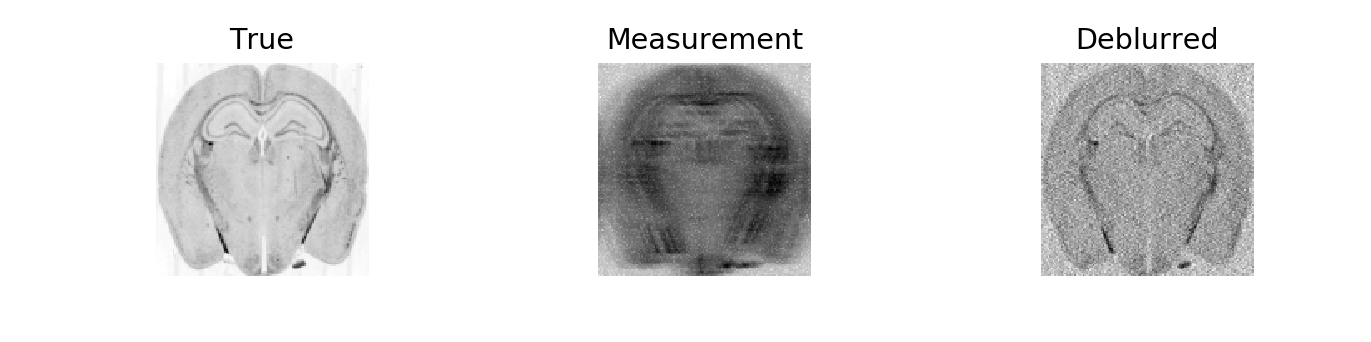

/home/sarah/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


<IPython.core.display.Javascript object>


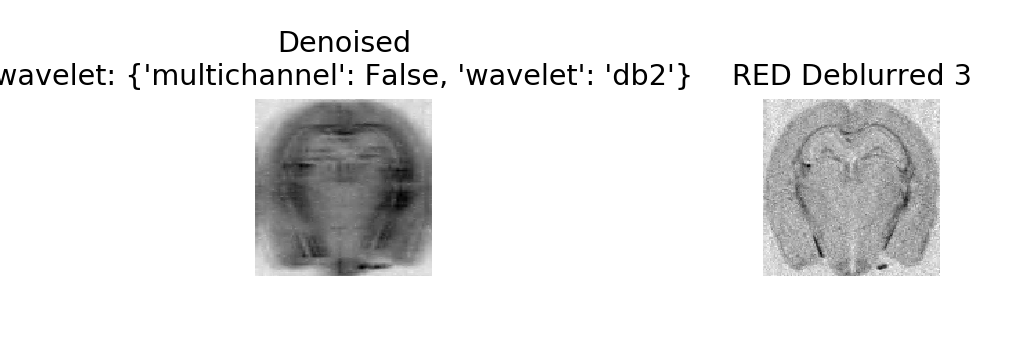

<IPython.core.display.Javascript object>


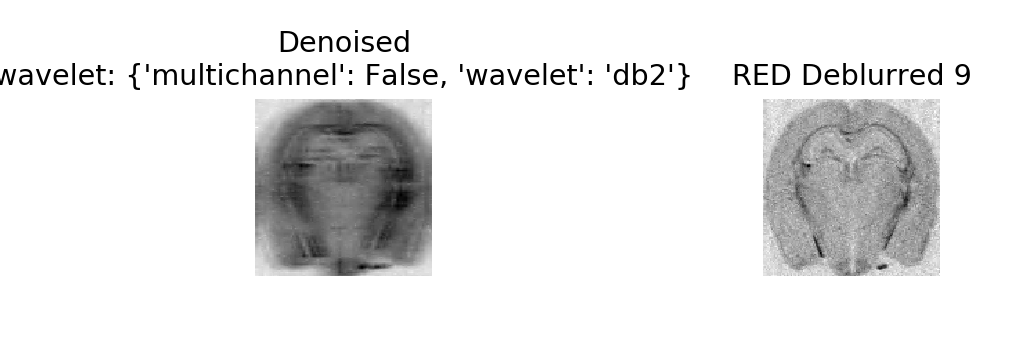

<IPython.core.display.Javascript object>


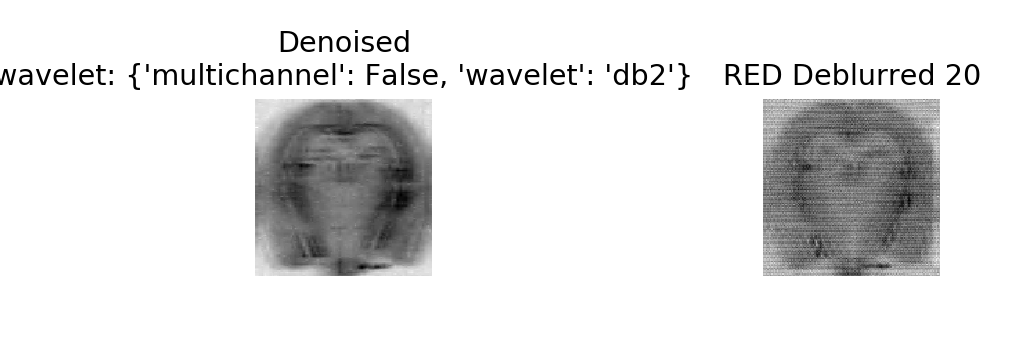

In [81]:
baseline_reconstruction(C,y)
for reg_weight in [3,9,20]:
    compare_reconstructions(C,y,reg_weight,denoise_type='wavelet',multichannel=False,wavelet='db2')

## Median Parameter Search

In [102]:
baseline_reconstruction(C,y)
for reg_weight in [0.01,0.1,0.5]: #[3,9,20]:
    compare_reconstructions(C,y,reg_weight,denoise_type='median',sk=True)

<IPython.core.display.Javascript object>

0.85870546
1.0855557


/home/sarah/anaconda3/lib/python3.6/site-packages/scikit_image-0.14.0-py3.6-linux-x86_64.egg/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


ValueError: Images of type float must be between -1 and 1.